<img src='https://www.unifor.br/o/unifor-theme/images/unifor-logo-horizontal.svg' width="250px">

# DATA HARVESTING / Projeto da Disciplina

Prof.: Ms. Alex Lima<br>
MBA em Ciência de Dados<br>
Universidade de Fortaleza

**Gabriela Ferreira Coutinho - 2418581**</br>

# 1. Capturando as URLs para Web Scraping

## 1.1 Instalação e Configuração 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

# 🔹 Configuração do Selenium para evitar bloqueios
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36")

# 🔹 Inicializa o WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

print("✅ Selenium configurado com sucesso!")

## 1.2 Acessar a Página Principal

In [ ]:
# 🔹 URL da página principal do torneio
url_base = "https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7"
driver.get(url_base)

# 🔹 Espera a página carregar totalmente
WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
time.sleep(5)  # Tempo extra para garantir carregamento

print("✅ Página carregada com sucesso!")

## 1.3 Abrir o Dropdown e Coletar as Temporadas

In [ ]:
# 🔹 Clicar no botão do dropdown para abrir a lista de temporadas
try:
    dropdown_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, "DropdownButton"))
    )
    dropdown_button.click()
    time.sleep(3)  # Espera os itens carregarem
except Exception as e:
    print("🚨 Erro ao abrir o dropdown das temporadas:", e)
    driver.quit()
    exit()

# 🔹 Coletar os IDs das temporadas
temporadas_urls = {}

try:
    # 🔹 Buscar a lista de temporadas toda vez antes de interagir
    temporadas_elements = driver.find_elements(By.XPATH, "//ul[@role='listbox']/li")
    temporadas_textos = [item.text.strip() for item in temporadas_elements]

    for nome_temporada in temporadas_textos:
        # 🔹 Reabre o dropdown para garantir que ele ainda está disponível
        dropdown_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "DropdownButton"))
        )
        dropdown_button.click()
        time.sleep(2)

        # 🔹 Rebusca a lista de temporadas antes de clicar
        temporadas_elements = driver.find_elements(By.XPATH, "//ul[@role='listbox']/li")

        for item in temporadas_elements:
            if item.text.strip() == nome_temporada:
                item.click()  # Seleciona a temporada para carregar a página correta
                time.sleep(3)

                # 🔹 Coletar o ID da URL após a seleção
                temporada_id = driver.current_url.split("#id:")[-1]
                url_final = f"https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7#id:{temporada_id}"
                temporadas_urls[nome_temporada] = url_final
                break

except Exception as e:
    print("🚨 Erro ao coletar as temporadas:", e)

print("✅ Temporadas coletadas com sucesso!")

## 1.4 Mostrar as 10 Temporadas Coletadas

In [ ]:
# 🔹 Filtrar apenas as 10 últimas temporadas
temporadas_filtradas = dict(list(temporadas_urls.items())[:10])

# 🔹 Exibe os IDs e URLs corrigidas
print("\n📌 Temporadas encontradas no Sofascore:")
for temporada, url in temporadas_filtradas.items():
    print(f"{temporada}: {url}")

## 1.5 Fechar o navegador 

In [ ]:
# 🔹 Fechar o navegador ao fim do processo
driver.quit()
print("✅ Navegador fechado com sucesso!")

## 1.6 Salvar temporadas como CSV

In [ ]:
import os
import pandas as pd

# 🔹 Criar a pasta 'data' caso não exista
os.makedirs("data", exist_ok=True)

# 🔹 Caminho do arquivo CSV
csv_path = "data/temporadas_urls.csv"

# 🔹 Converter dicionário para DataFrame e salvar
df_temporadas = pd.DataFrame(list(temporadas_filtradas.items()), columns=["Temporada", "URL"])
df_temporadas.to_csv(csv_path, index=False, encoding="utf-8")

print(f"✅ Temporadas salvas em {csv_path}!")

# 2. Capturar dados dos jogadores das temporadas

## 2.1 Carregar as Temporadas do CSV

In [ ]:
import pandas as pd

# 🔹 Caminho do arquivo CSV salvo anteriormente
csv_path = "data/temporadas_urls.csv"

# 🔹 Carregar o CSV e transformar em dicionário {Temporada: URL}
df_temporadas = pd.read_csv(csv_path)
temporadas_urls = dict(zip(df_temporadas["Temporada"], df_temporadas["URL"]))

print(f"✅ {len(temporadas_urls)} temporadas carregadas do CSV para scraping.")

## 2.2 Função para Coletar Dados de uma Temporada

### 2.2.1 Configuração Inicial

In [ ]:
# 🔹 Importação das bibliotecas necessárias
import os
import time
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# 🔹 Configuração do Selenium para evitar bloqueios
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# 🔹 Criar a pasta "data" para armazenar os resultados
os.makedirs("data", exist_ok=True)

print("✅ Configuração inicial concluída!")

✅ Configuração inicial concluída!


### 2.2.2 Carregar Temporadas do CSV

In [45]:
# 🔹 Carregar as URLs das temporadas do arquivo CSV
csv_path = "data/temporadas_urls.csv"

if os.path.exists(csv_path):
    df_temporadas = pd.read_csv(csv_path)
    temporadas_urls = dict(zip(df_temporadas["Temporada"], df_temporadas["URL"]))
    print(f"✅ {len(temporadas_urls)} temporadas carregadas do CSV para scraping.")
else:
    print("❌ Arquivo de temporadas não encontrado. Execute a etapa de coleta de URLs primeiro!")

✅ 10 temporadas carregadas do CSV para scraping.


### 2.2.3 Função para Coletar Estatísticas dos Jogadores

In [46]:
# 🔹 Mapeamento das abas desejadas para coleta de estatísticas
abas_desejadas = {
    "attack": "Ataque",
    "defence": "Defesa",
    "passing": "Passe",
    "goalkeeper": "Goleiro"
}

def coletar_dados_temporada(temporada, url):
    print(f"\n🔄 Acessando temporada {temporada}: {url}")

    driver.get(url)
    time.sleep(5)

    try:
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.TAG_NAME, "table"))
        )

        for aba_id, nome_aba in abas_desejadas.items():
            print(f"\n🟡 Coletando dados da aba {nome_aba}...")

            # Clicar na aba correta
            try:
                aba_botao = driver.find_element(By.XPATH, f"//button[@data-tabid='{aba_id}']")
                driver.execute_script("arguments[0].click();", aba_botao)
                time.sleep(3)
            except:
                print(f"❌ Não foi possível acessar a aba {nome_aba}. Pulando...")
                continue

            dados_totais = []
            pagina = 1

            while True:
                print(f"📄 Coletando página {pagina} da aba {nome_aba}...")

                # Pegar HTML da página e processar com BeautifulSoup
                page_source = driver.page_source
                soup = BeautifulSoup(page_source, "html.parser")

                tabela = soup.find("table")
                if not tabela:
                    print(f"⚠️ Tabela não encontrada na aba {nome_aba}.")
                    break

                # Capturar cabeçalhos
                cabecalhos = [th.text.strip() for th in tabela.find_all("th")]
                cabecalhos.insert(1, "Time")  # Adicionar a coluna "Time"

                # Capturar linhas da tabela
                linhas = tabela.find_all("tr")[1:]  # Ignorar cabeçalho
                for linha in linhas:
                    colunas = linha.find_all("td")

                    if colunas:
                        # Pega o nome do time pela imagem
                        time_element = colunas[1].find("img")
                        nome_time = time_element["alt"] if time_element else "Desconhecido"

                        # Captura os valores das colunas
                        dados_linha = [coluna.text.strip() for coluna in colunas]

                        # Capturar "Nota Sofascore" corretamente
                        try:
                            nota_sofascore = colunas[-1].find("span").text.strip()
                        except:
                            nota_sofascore = ""

                        # Adicionar a nota ao final da linha
                        dados_linha.append(nota_sofascore)

                        # Inserir o nome do time na segunda posição
                        dados_linha.insert(1, nome_time)

                        dados_totais.append(dados_linha)

                # Tentar clicar no botão "Próxima Página"
                try:
                    botao_proximo = driver.find_element(By.XPATH, "//button[@style='justify-content: flex-end;']")
                    if botao_proximo.is_enabled():
                        driver.execute_script("arguments[0].click();", botao_proximo)
                        time.sleep(3)  # Esperar carregamento
                        pagina += 1
                    else:
                        print(f"✅ Todas as páginas da aba {nome_aba} foram coletadas!")
                        break
                except:
                    print(f"✅ Última página da aba {nome_aba} alcançada.")
                    break

            # Criar a pasta específica para a aba e temporada
            pasta_temporada = f"data/{nome_aba}/{temporada.replace('/', '-')}"
            os.makedirs(pasta_temporada, exist_ok=True)

            # Salvar em CSV
            if dados_totais:
                df = pd.DataFrame(dados_totais, columns=cabecalhos + ["Nota Sofascore"])
                nome_arquivo = f"{pasta_temporada}/estatisticas_jogadores.csv"
                df.to_csv(nome_arquivo, index=False, encoding="utf-8")
                print(f"✅ Dados da aba {nome_aba} salvos em {nome_arquivo}")
            else:
                print(f"❌ Nenhum dado encontrado na aba {nome_aba}.")

    except Exception as e:
        print(f"🚨 Erro ao carregar a página da temporada {temporada}: {e}")

### 2.2.4 Executar Web Scraping para Todas as Temporadas

In [47]:
# 🔹 Executar a coleta de estatísticas para todas as temporadas
for temporada, url in temporadas_urls.items():
    coletar_dados_temporada(temporada, url)

# 🔹 Fechar o navegador ao final do processo
driver.quit()
print("✅ Web scraping concluído! Navegador fechado.")


🔄 Acessando temporada 23/24: https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7#id:52162

🟡 Coletando dados da aba Ataque...
📄 Coletando página 1 da aba Ataque...
📄 Coletando página 2 da aba Ataque...
📄 Coletando página 3 da aba Ataque...
📄 Coletando página 4 da aba Ataque...
📄 Coletando página 5 da aba Ataque...
📄 Coletando página 6 da aba Ataque...
📄 Coletando página 7 da aba Ataque...
📄 Coletando página 8 da aba Ataque...
📄 Coletando página 9 da aba Ataque...
📄 Coletando página 10 da aba Ataque...
📄 Coletando página 11 da aba Ataque...
📄 Coletando página 12 da aba Ataque...
📄 Coletando página 13 da aba Ataque...
📄 Coletando página 14 da aba Ataque...
📄 Coletando página 15 da aba Ataque...
📄 Coletando página 16 da aba Ataque...
📄 Coletando página 17 da aba Ataque...
📄 Coletando página 18 da aba Ataque...
📄 Coletando página 19 da aba Ataque...
📄 Coletando página 20 da aba Ataque...
📄 Coletando página 21 da aba Ataque...
📄 Coletando página 22 da aba Ataque...


# 3. Recuperação de informação

## 3.1 Limpeza dos Dados

### 3.1.1 Importação de bibliotecas

In [41]:
import os
import pandas as pd

### 3.1.2 Definição de diretórios e categorias

In [42]:
# 🔹 Definir o diretório base
base_dir = "data"
categorias = ["Ataque", "Defesa", "Passe", "Goleiro"]

# 🔹 Criar um dicionário para armazenar os DataFrames por temporada
dados_temporadas = {}

### 3.1.3 Percorrer todas as categorias e processar os dados

In [43]:
# 🔹 Percorrer todas as categorias
for categoria in categorias:
    categoria_dir = os.path.join(base_dir, categoria)

    if not os.path.exists(categoria_dir):
        continue  # Se a pasta não existir, pula para a próxima

    print(f"\n🔄 Processando categoria: {categoria}")

    # 🔹 Percorrer todas as temporadas dentro da categoria
    for temporada in os.listdir(categoria_dir):
        temporada_dir = os.path.join(categoria_dir, temporada)
        arquivo_csv = os.path.join(temporada_dir, "estatisticas_jogadores.csv")

        if not os.path.exists(arquivo_csv):
            continue  # Se o arquivo não existir, pula para a próxima

        print(f"📂 Carregando {arquivo_csv}")

        # 🔹 Carregar o CSV
        df = pd.read_csv(arquivo_csv)

        # 🔹 Corrigir nome da coluna "Time" (se existir)
        if "Time" in df.columns:
            df.rename(columns={"Time": "Clube"}, inplace=True)  # Substitui "Time" por "Clube"

        # 🔹 Remover colunas vazias ou não utilizadas
        df.dropna(how="all", axis=1, inplace=True)  # Remove colunas completamente vazias

        # 🔹 Remover colunas duplicadas
        df = df.loc[:, ~df.columns.duplicated()]
        
        # 🔹 Tratar valores ausentes sem usar inplace=True
        for col in df.columns:
            if df[col].dtype == "object":  
                df[col] = df[col].fillna("N/A")  # Para colunas de texto, substituir por "N/A"
            else:
                df[col] = df[col].fillna(0.0)  # Para colunas numéricas, substituir por 0.0

        # 🔹 Adicionar categoria ao DataFrame
        df["Categoria"] = categoria  

        # 🔹 Criar DataFrame para a temporada caso ainda não exista
        if temporada not in dados_temporadas:
            dados_temporadas[temporada] = df
        else:
            # 🔹 Concatenar com os dados já existentes para aquela temporada
            dados_temporadas[temporada] = pd.concat([dados_temporadas[temporada], df], ignore_index=True)


🔄 Processando categoria: Ataque
📂 Carregando data/Ataque/20-21/estatisticas_jogadores.csv
📂 Carregando data/Ataque/15-16/estatisticas_jogadores.csv
📂 Carregando data/Ataque/22-23/estatisticas_jogadores.csv
📂 Carregando data/Ataque/23-24/estatisticas_jogadores.csv
📂 Carregando data/Ataque/14-15/estatisticas_jogadores.csv
📂 Carregando data/Ataque/18-19/estatisticas_jogadores.csv
📂 Carregando data/Ataque/21-22/estatisticas_jogadores.csv
📂 Carregando data/Ataque/19-20/estatisticas_jogadores.csv
📂 Carregando data/Ataque/16-17/estatisticas_jogadores.csv
📂 Carregando data/Ataque/17-18/estatisticas_jogadores.csv

🔄 Processando categoria: Defesa
📂 Carregando data/Defesa/20-21/estatisticas_jogadores.csv
📂 Carregando data/Defesa/15-16/estatisticas_jogadores.csv
📂 Carregando data/Defesa/22-23/estatisticas_jogadores.csv
📂 Carregando data/Defesa/23-24/estatisticas_jogadores.csv
📂 Carregando data/Defesa/14-15/estatisticas_jogadores.csv
📂 Carregando data/Defesa/18-19/estatisticas_jogadores.csv
📂 Carr

### 3.1.4 Criar diretório para salvar os arquivos unificados

In [44]:
# 🔹 Criar pasta para os arquivos unificados
output_dir = "data_unificada"
os.makedirs(output_dir, exist_ok=True)

### 3.1.5 Salvar os dados unificados por temporada

In [45]:
# 🔹 Salvar cada temporada como um único CSV
for temporada, df in dados_temporadas.items():
    output_file = os.path.join(output_dir, f"estatisticas_{temporada}.csv")
    df.to_csv(output_file, index=False, encoding="utf-8")
    print(f"✅ Temporada {temporada} limpa, unificada e salva em {output_file}")

print("\n🎯 🔹 Processamento concluído! Todos os dados foram limpos e unificados.")

✅ Temporada 20-21 limpa, unificada e salva em data_unificada/estatisticas_20-21.csv
✅ Temporada 15-16 limpa, unificada e salva em data_unificada/estatisticas_15-16.csv
✅ Temporada 22-23 limpa, unificada e salva em data_unificada/estatisticas_22-23.csv
✅ Temporada 23-24 limpa, unificada e salva em data_unificada/estatisticas_23-24.csv
✅ Temporada 14-15 limpa, unificada e salva em data_unificada/estatisticas_14-15.csv
✅ Temporada 18-19 limpa, unificada e salva em data_unificada/estatisticas_18-19.csv
✅ Temporada 21-22 limpa, unificada e salva em data_unificada/estatisticas_21-22.csv
✅ Temporada 19-20 limpa, unificada e salva em data_unificada/estatisticas_19-20.csv
✅ Temporada 16-17 limpa, unificada e salva em data_unificada/estatisticas_16-17.csv
✅ Temporada 17-18 limpa, unificada e salva em data_unificada/estatisticas_17-18.csv

🎯 🔹 Processamento concluído! Todos os dados foram limpos e unificados.


### 3.1.6 Criar um Dicionário de Colunas por Categoria

In [46]:
# 🔹 Criar um dicionário fixo para definir as colunas relevantes por categoria
colunas_por_categoria = {
    "Ataque": [
        "Nome", "Clube", "Gols", "Gols esperados (xG)", "Grandes chances perdidases", 
        "Dribles certos", "Finalizações", "Conversão de gols %", "Nota Sofascore"
    ],
    "Defesa": [
        "Nome", "Clube", "Desarmes", "Interceptações", "Cortes", 
        "Erros que levaram ao gol", "Nota Sofascore"
    ],
    "Passe": [
        "Nome", "Clube", "Grandes chances criadas", "Assistências", 
        "Passes certos", "Passes certos %", "Passes decisivos", "Nota Sofascore"
    ],
    "Goleiro": [
        "Nome", "Clube", "Defesas", "Pênalti defendido", "Jogos sem ser vazado", 
        "Defesas de dentro da área", "Saídas do gol", "Nota Sofascore"
    ]
}

print("✅ Dicionário de colunas por categoria criado!")

✅ Dicionário de colunas por categoria criado!


### 3.1.7 Definir diretório de dados

In [47]:
import os
import pandas as pd

# 🔹 Diretório onde estão os CSVs unificados
output_dir = "data_unificada"

print(f"📂 Diretório de saída definido: {output_dir}")

📂 Diretório de saída definido: data_unificada


### 3.1.8 Aplicar Filtro de Colunas em Cada CSV

In [49]:
# 🔹 Processar cada arquivo CSV unificado por temporada
for arquivo in os.listdir(output_dir):
    if not arquivo.endswith(".csv"):
        continue

    caminho_arquivo = os.path.join(output_dir, arquivo)
    print(f"\n📂 Ajustando {caminho_arquivo}")

    # 🔹 Carregar CSV
    df = pd.read_csv(caminho_arquivo)

    # 🔹 Criar uma cópia do DataFrame para evitar problemas com índices
    df_filtrado = df.copy()

    # 🔹 Manter apenas as colunas relevantes para cada categoria
    for categoria, colunas in colunas_por_categoria.items():
        df_categoria = df["Categoria"] == categoria  # Filtrar linhas dessa categoria

        # 🔹 Verificar quais colunas existem no DataFrame antes de aplicar
        colunas_existentes = [col for col in colunas if col in df.columns]

        # 🔹 Reduzir o DataFrame para conter apenas as colunas certas
        df_filtrado.loc[df_categoria, colunas_existentes] = df.loc[df_categoria, colunas_existentes]

    # 🔹 Salvar o arquivo atualizado
    df_filtrado.to_csv(caminho_arquivo, index=False, encoding="utf-8")
    print(f"✅ Ajustado e salvo: {caminho_arquivo}")

print("\n🎯 🔹 Processamento concluído! Apenas colunas relevantes foram mantidas para cada categoria.")


📂 Ajustando data_unificada/estatisticas_16-17.csv
✅ Ajustado e salvo: data_unificada/estatisticas_16-17.csv

📂 Ajustando data_unificada/estatisticas_14-15.csv
✅ Ajustado e salvo: data_unificada/estatisticas_14-15.csv

📂 Ajustando data_unificada/estatisticas_23-24.csv
✅ Ajustado e salvo: data_unificada/estatisticas_23-24.csv

📂 Ajustando data_unificada/estatisticas_21-22.csv
✅ Ajustado e salvo: data_unificada/estatisticas_21-22.csv

📂 Ajustando data_unificada/estatisticas_19-20.csv
✅ Ajustado e salvo: data_unificada/estatisticas_19-20.csv

📂 Ajustando data_unificada/estatisticas_17-18.csv
✅ Ajustado e salvo: data_unificada/estatisticas_17-18.csv

📂 Ajustando data_unificada/estatisticas_15-16.csv
✅ Ajustado e salvo: data_unificada/estatisticas_15-16.csv

📂 Ajustando data_unificada/estatisticas_20-21.csv
✅ Ajustado e salvo: data_unificada/estatisticas_20-21.csv

📂 Ajustando data_unificada/estatisticas_18-19.csv
✅ Ajustado e salvo: data_unificada/estatisticas_18-19.csv

📂 Ajustando data_u

Se "Gols esperados (xG)" não estiver presente em uma temporada, o código não tentará forçar sua inclusão.  
✅ **Criação de uma cópia do DataFrame** → Isso previne problemas com índices ao manipular os dados.  
✅ **Maior segurança na filtragem** → Garantimos que cada categoria tenha apenas os dados relevantes.  

## 3.2 Análise

### 3.2.1 Importar Bibliotecas e Configurar Estilo dos Gráficos

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Configuração de estilo
plt.style.use("ggplot")

### 3.2.2 Carregar os arquivos CSV unificados

In [51]:
# Definir diretório onde estão os dados unificados
output_dir = "data_unificada"

# Lista para armazenar os DataFrames de cada temporada
dfs = []

# Percorrer os arquivos e carregar os dados
for arquivo in os.listdir(output_dir):
    if arquivo.endswith(".csv"):
        temporada = arquivo.replace("estatisticas_", "").replace(".csv", "")
        df = pd.read_csv(os.path.join(output_dir, arquivo))
        df["Temporada"] = temporada  # Adicionar a temporada ao DataFrame
        dfs.append(df)

# Concatenar todos os DataFrames em um único
df_geral = pd.concat(dfs, ignore_index=True)

print(f"✅ Dados carregados com sucesso! {df_geral.shape[0]} registros no total.")

✅ Dados carregados com sucesso! 22642 registros no total.


### 3.2.3 Tendência de Desempenho ao Longo das Temporadas

#### Número de Gols

/Users/gabe/champions-league-analysis/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


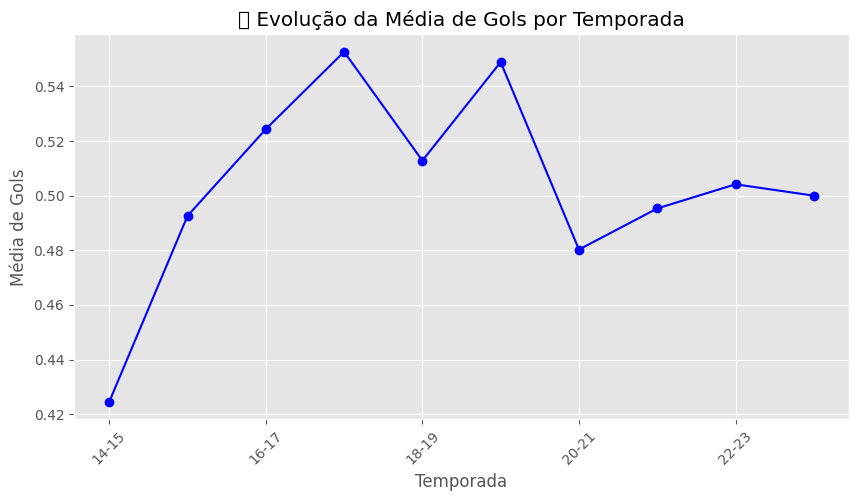

In [52]:
# Agrupar por temporada e calcular a média de gols
df_gols = df_geral.groupby("Temporada")["Gols"].mean()

# Criar o gráfico de evolução dos gols
plt.figure(figsize=(10, 5))
df_gols.plot(marker="o", color="b")
plt.title("📊 Evolução da Média de Gols por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Média de Gols")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Assistências

/Users/gabe/champions-league-analysis/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


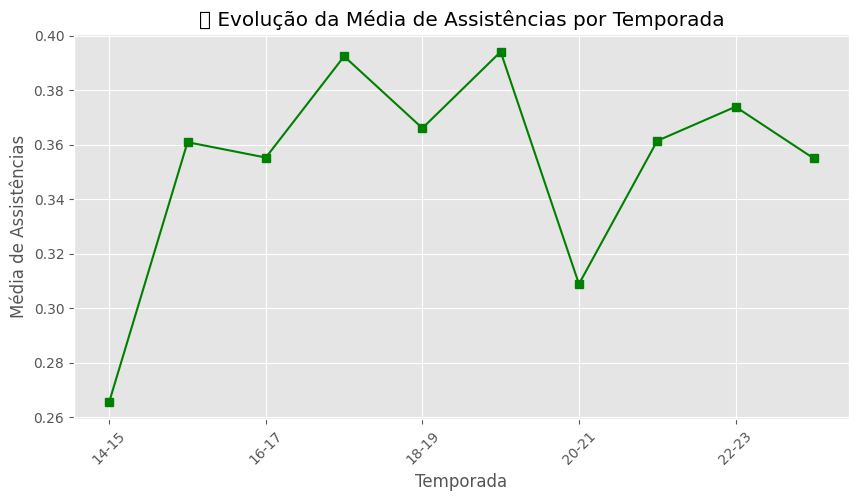

In [53]:
# Agrupar por temporada e calcular a média de assistências
df_assistencias = df_geral.groupby("Temporada")["Assistências"].mean()

# Criar o gráfico de evolução das assistências
plt.figure(figsize=(10, 5))
df_assistencias.plot(marker="s", color="g")
plt.title("📊 Evolução da Média de Assistências por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Média de Assistências")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Defesas de Goleiros

/Users/gabe/champions-league-analysis/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


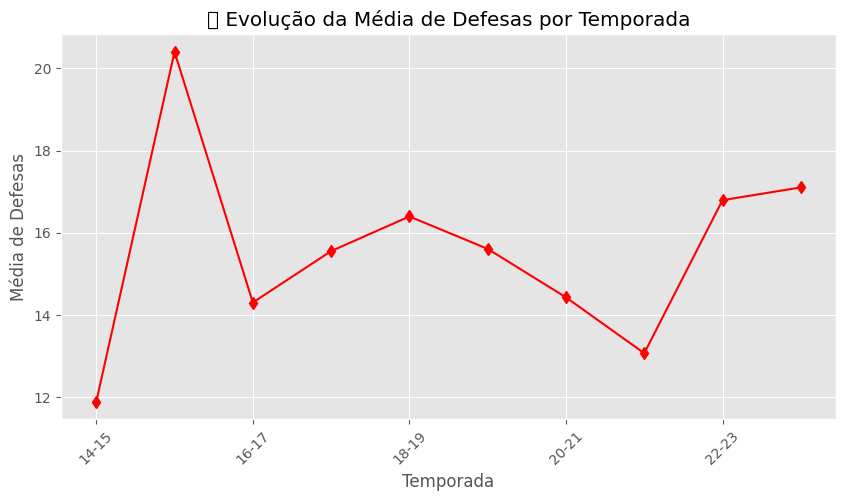

In [54]:
# Filtrar apenas os goleiros
df_goleiros = df_geral[df_geral["Categoria"] == "Goleiro"]

# Agrupar por temporada e calcular a média de defesas
df_defesas = df_goleiros.groupby("Temporada")["Defesas"].mean()

# Criar o gráfico de evolução das defesas
plt.figure(figsize=(10, 5))
df_defesas.plot(marker="d", color="r")
plt.title("📊 Evolução da Média de Defesas por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Média de Defesas")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Clubes com Melhor Desempenho ao Longo das Temporadas

In [55]:
# Agrupar por clube e temporada, calculando a média da Nota Sofascore
df_clubes = df_geral.groupby(["Temporada", "Clube"])["Nota Sofascore"].mean().reset_index()

# Ordenar por temporada e nota
df_clubes_top = df_clubes.sort_values(["Temporada", "Nota Sofascore"], ascending=[True, False])

# Exibir os 10 melhores clubes de cada temporada
for temporada in df_clubes_top["Temporada"].unique():
    print(f"\n📊 Top Clubes na Temporada {temporada}")
    display(df_clubes_top[df_clubes_top["Temporada"] == temporada].head(10))


📊 Top Clubes na Temporada 14-15


,Temporada,Clube,Nota Sofascore
40,14-15,Real Madrid,7.298873
7,14-15,Barcelona,7.169552
5,14-15,Atlético Madrid,7.092535
18,14-15,FC Porto,7.009014
11,14-15,Borussia Dortmund,7.004459
3,14-15,Arsenal,6.938778
33,14-15,Manchester City,6.911803
43,14-15,Shakhtar Donetsk,6.889672
29,14-15,Liverpool,6.870781
9,14-15,Bayer 04 Leverkusen,6.859687



📊 Top Clubes na Temporada 15-16


,Temporada,Clube,Nota Sofascore
75,15-16,Real Madrid,7.200882
61,15-16,FC Bayern München,7.155493
54,15-16,Barcelona,7.060137
52,15-16,Atlético Madrid,7.049857
59,15-16,Chelsea,6.999077
62,15-16,FC Porto,6.938364
72,15-16,Olympique Lyonnais,6.925000
50,15-16,Arsenal,6.898108
55,15-16,Bayer 04 Leverkusen,6.889818
69,15-16,Manchester City,6.889706



📊 Top Clubes na Temporada 16-17


,Temporada,Clube,Nota Sofascore
96,16-17,FC Bayern München,7.025538
110,16-17,Real Madrid,7.014225
107,16-17,Olympique Lyonnais,7.005469
111,16-17,Sevilla,6.981343
83,16-17,Arsenal,6.970469
113,16-17,Tottenham Hotspur,6.942031
84,16-17,Atlético Madrid,6.941290
101,16-17,Juventus,6.933506
87,16-17,Bayer 04 Leverkusen,6.906250
85,16-17,Barcelona,6.901690



📊 Top Clubes na Temporada 17-18


,Temporada,Clube,Nota Sofascore
132,17-18,Manchester United,7.098571
125,17-18,FC Bayern München,7.086176
136,17-18,Paris Saint-Germain,7.070690
140,17-18,Real Madrid,7.037042
130,17-18,Liverpool,7.015342
117,17-18,Barcelona,7.008088
131,17-18,Manchester City,6.986234
142,17-18,Sevilla,6.950735
116,17-18,Atlético Madrid,6.929508
141,17-18,Roma,6.912459



📊 Top Clubes na Temporada 18-19


,Temporada,Clube,Nota Sofascore
170,18-19,Real Madrid,7.090135
164,18-19,Manchester City,7.081563
150,18-19,Barcelona,7.059324
155,18-19,FC Bayern München,6.959836
162,18-19,Liverpool,6.919344
161,18-19,Juventus,6.909104
166,18-19,Napoli,6.894364
147,18-19,AFC Ajax,6.894328
171,18-19,Roma,6.892432
169,18-19,Paris Saint-Germain,6.884516



📊 Top Clubes na Temporada 19-20


,Temporada,Clube,Nota Sofascore
201,19-20,Paris Saint-Germain,7.057297
181,19-20,Barcelona,7.052297
197,19-20,Manchester City,7.000735
195,19-20,Liverpool,6.955968
180,19-20,Atlético Madrid,6.916563
203,19-20,Real Madrid,6.909054
191,19-20,Inter,6.897069
187,19-20,FC Bayern München,6.874426
209,19-20,Zenit St. Petersburg,6.860169
202,19-20,RB Leipzig,6.830270



📊 Top Clubes na Temporada 20-21


,Temporada,Clube,Nota Sofascore
226,20-21,Juventus,7.075735
230,20-21,Manchester City,7.020909
217,20-21,Chelsea,7.020000
220,20-21,FC Bayern München,6.964625
228,20-21,Liverpool,6.964333
213,20-21,Barcelona,6.944940
236,20-21,Real Madrid,6.923289
215,20-21,Borussia Dortmund,6.869875
234,20-21,Paris Saint-Germain,6.869000
212,20-21,Atlético Madrid,6.843115



📊 Top Clubes na Temporada 21-22


,Temporada,Clube,Nota Sofascore
252,21-22,FC Bayern München,7.098243
249,21-22,Chelsea,6.980270
259,21-22,Manchester City,6.957037
242,21-22,AFC Ajax,6.916615
262,21-22,Paris Saint-Germain,6.914923
254,21-22,Inter,6.878143
260,21-22,Manchester United,6.820312
243,21-22,Atalanta,6.786230
266,21-22,Sevilla,6.777761
263,21-22,RB Leipzig,6.771324



📊 Top Clubes na Temporada 22-23


,Temporada,Clube,Nota Sofascore
292,22-23,Manchester City,7.105735
284,22-23,FC Bayern München,7.094359
294,22-23,Napoli,7.025075
299,22-23,Real Madrid,6.950882
290,22-23,Liverpool,6.903947
276,22-23,Barcelona,6.892750
304,22-23,Tottenham Hotspur,6.892338
281,22-23,Chelsea,6.885875
279,22-23,Borussia Dortmund,6.871375
288,22-23,Inter,6.871343



📊 Top Clubes na Temporada 23-24


,Temporada,Clube,Nota Sofascore
330,23-24,Real Madrid,7.142500
313,23-24,FC Bayern München,7.029054
311,23-24,Borussia Dortmund,7.008028
327,23-24,Paris Saint-Germain,6.992031
309,23-24,Barcelona,6.977922
321,23-24,Manchester City,6.946364
328,23-24,RB Leipzig,6.937887
307,23-24,Arsenal,6.934789
319,23-24,Inter,6.922500
315,23-24,FC Porto,6.867763
